<a href="https://colab.research.google.com/github/malgorzatakolka/CardiovascularDisease/blob/main/Cardiovascular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cardiovascular disease predictions

Dataset: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset?resource=download

Features:

    Age | Objective Feature | age | int (days)
    Height | Objective Feature | height | int (cm) |
    Weight | Objective Feature | weight | float (kg) |
    Gender | Objective Feature | gender | 1: woman, 2: man |
    Systolic blood pressure | Examination Feature | ap_hi | int |
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    Smoking | Subjective Feature | smoke | binary |
    Alcohol intake | Subjective Feature | alco | binary |
    Physical activity | Subjective Feature | active | binary |
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


# Imports and helper functions

In [1]:
!pip install -q sweetviz df-squeezer phik Boruta jupyter-black shap
import jupyter_black
jupyter_black.load()
from df_squeezer import df_squeezer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as sv
import seaborn as sns
from phik import resources, report
from phik import phik_matrix
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split, \
                                    RandomizedSearchCV
from sklearn.metrics import  classification_report, confusion_matrix, \
                             precision_recall_curve, f1_score
from boruta import BorutaPy
from scipy.cluster.hierarchy import dendrogram, linkage

from google.colab import drive
drive.mount('/content/drive')
url = '/content/drive/MyDrive/Colab/Cardiovascular/'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.8 MB/s eta 0:00:00


Mounted at /content/drive


In [2]:
# helper functions
import pandas as pd
from scipy.stats import chi2_contingency
from typing import Union

def print_val_score(val_score: pd.Series) -> None:
    """
    Print validation scores and mean accuracy score with standard deviation.

    Args:
    val_score : pd.Series
        The validation scores to be printed.

    Returns:
    None
    """
    print(f'Validation scores: {val_score}')
    print(f"Mean accuracy score: {val_score.mean():.3f} \
            (+/- {val_score.std() * 2:.3f})")

def chi2_test(col1: pd.Series, col2: pd.Series) -> None:
    """
    Perform a Chi-square test of independence between two categorical variables.

    Args:
    col1 : pd.Series
        The first categorical variable.
    col2 : pd.Series
        The second categorical variable.
    Returns:
    None
    """
    contingency_table = pd.crosstab(col1, col2)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print("Chi-square test statistic:", round(chi2, 3))
    print("p-value:", round(p, 3))
    alpha = 0.05
    if p < alpha:
        print("The association with 'cardio' is statistically \
        significant (p < 0.05).")
    else:
        print("The association with 'cardio' is not statistically \
        significant (p >= 0.05).")


# Data familiarisation

In [3]:
data_url = url + 'cardio_train.csv'
df = pd.read_csv(data_url, delimiter=';', index_col=0)
df = df_squeezer(df, report=True, edit=True)
df.head()

Suggested conversion for column 'age': int64 -> int16
Suggested conversion for column 'gender': int64 -> int8
Suggested conversion for column 'height': int64 -> int16
Suggested conversion for column 'weight': float64 -> float32
Suggested conversion for column 'ap_hi': int64 -> int16
Suggested conversion for column 'ap_lo': int64 -> int16
Suggested conversion for column 'cholesterol': int64 -> int8
Suggested conversion for column 'gluc': int64 -> int8
Suggested conversion for column 'smoke': int64 -> int8
Suggested conversion for column 'alco': int64 -> int8
Suggested conversion for column 'active': int64 -> int8
Suggested conversion for column 'cardio': int64 -> int8

Original total memory usage: 6.94 MB
New total memory usage: 1.8 MB
Memory saved: 5.14 MB

# Executable Python code for suggested dtype conversions:


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.00,110,80,1,1,0,0,1,0
1,20228,1,156,85.00,140,90,3,1,0,0,1,1
2,18857,1,165,64.00,130,70,3,1,0,0,0,1
3,17623,2,169,82.00,150,100,1,1,0,0,1,1
4,17474,1,156,56.00,100,60,1,1,0,0,0,0


Assesing impact of duplicates

In [45]:
print('Total duplicates: ', df.duplicated().sum())
duplicated_rows = df.duplicated(keep=False)
df_duplicated = df[duplicated_rows]
df_not_duplicated = df[~duplicated_rows]
proportion_duplicated = df_duplicated['cardio'].value_counts(normalize=True)
proportion_not_duplicated = df_not_duplicated['cardio'].value_counts(normalize=True)
print("Proportion of target values for duplicated rows:")
print(proportion_duplicated)
print("\nProportion of target values for not duplicated rows:")
print(proportion_not_duplicated)

Total duplicates:  24
Proportion of target values for duplicated rows:
cardio
0   0.71
1   0.29
Name: proportion, dtype: float64

Proportion of target values for not duplicated rows:
cardio
0   0.50
1   0.50
Name: proportion, dtype: float64


Although the proportions for duplicated values are different for patients with and without cardiovascular disease, as there is only 24 of those values lets remove them.

In [46]:
df.drop_duplicates(inplace=True)

                                             |          | [  0%]   00:00 -> (? left)


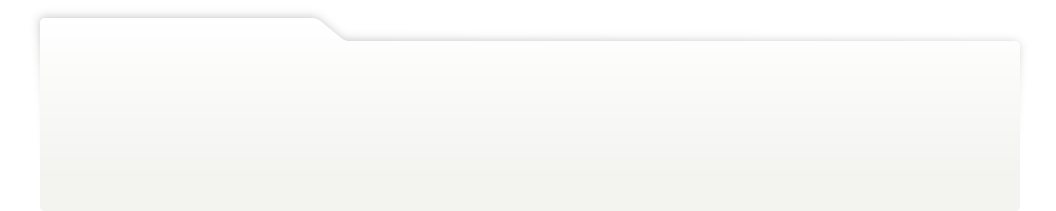
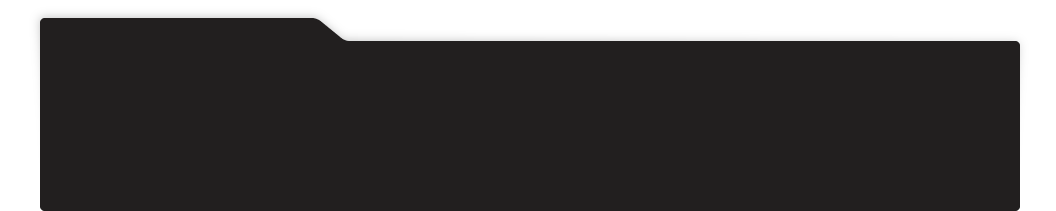
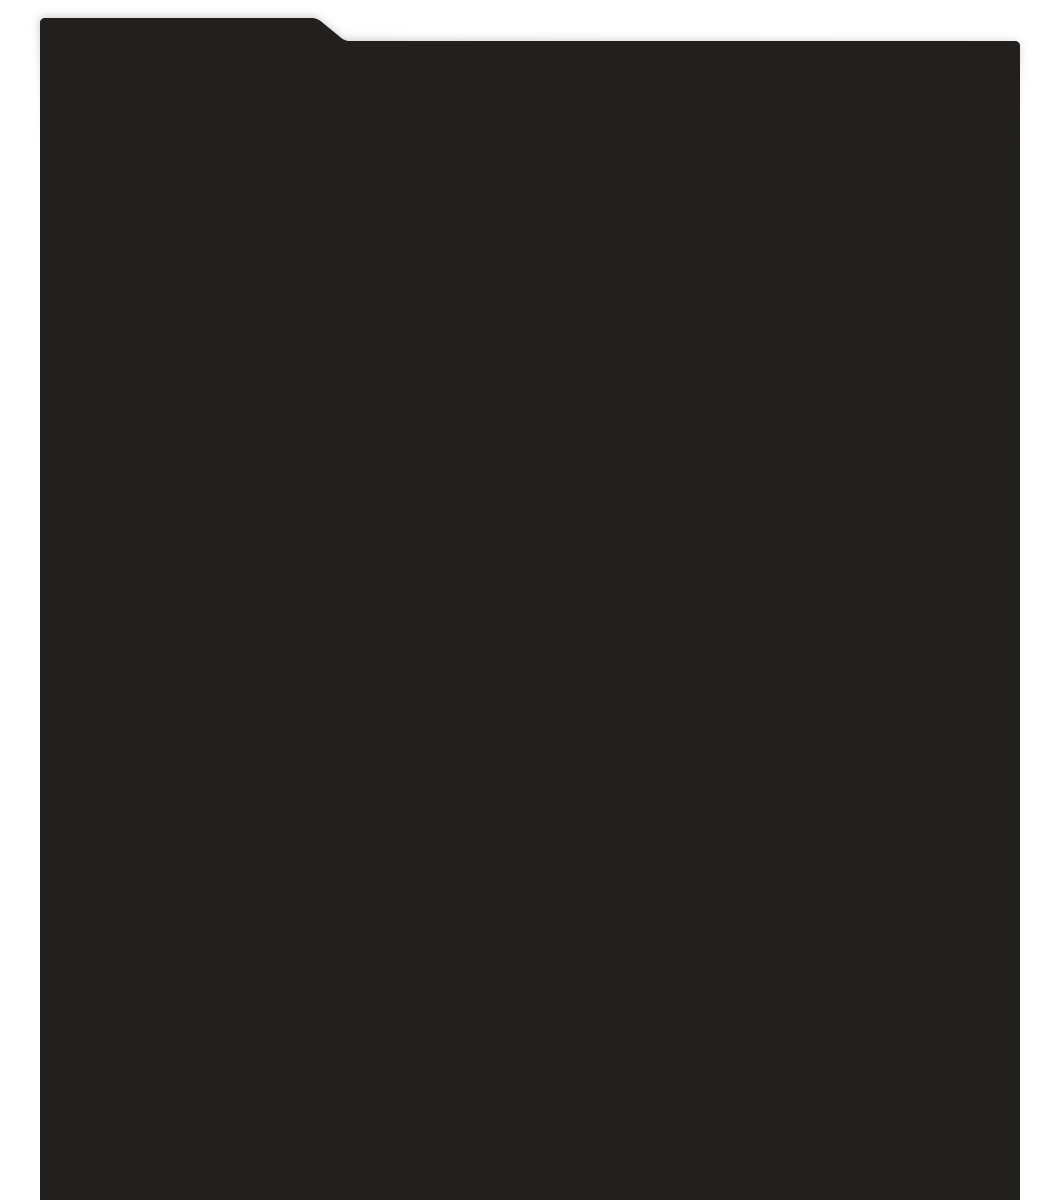
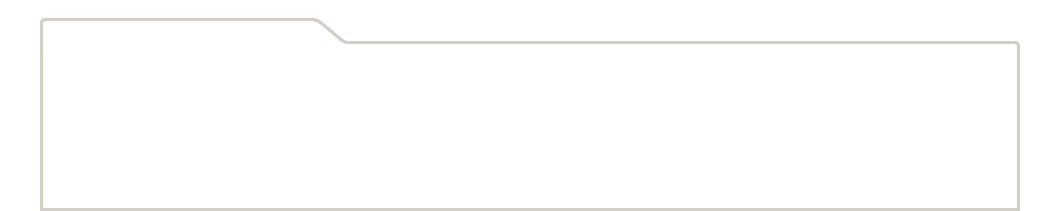
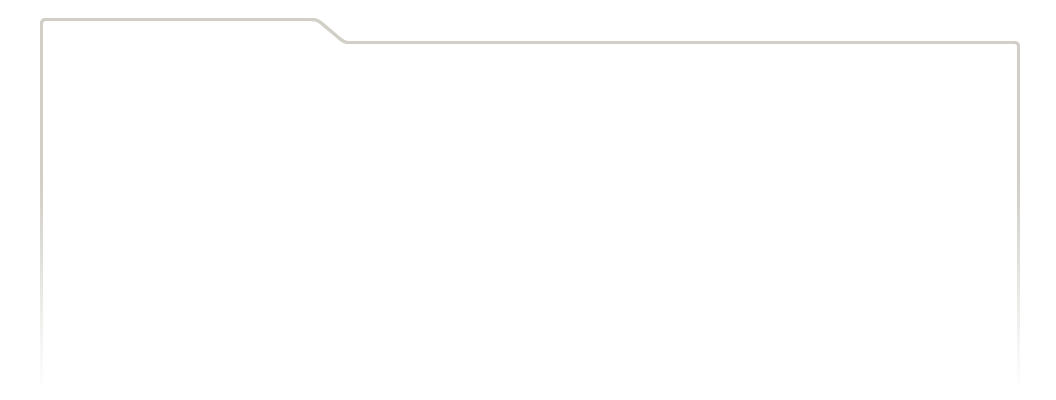
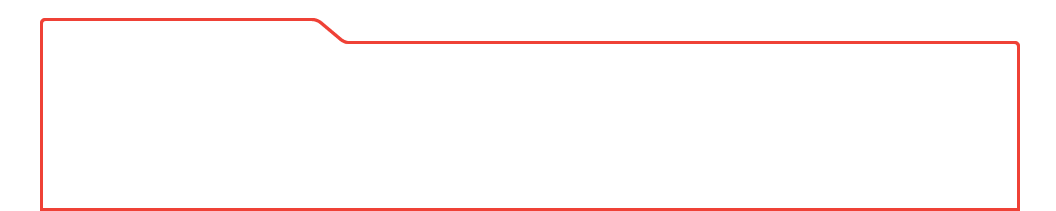
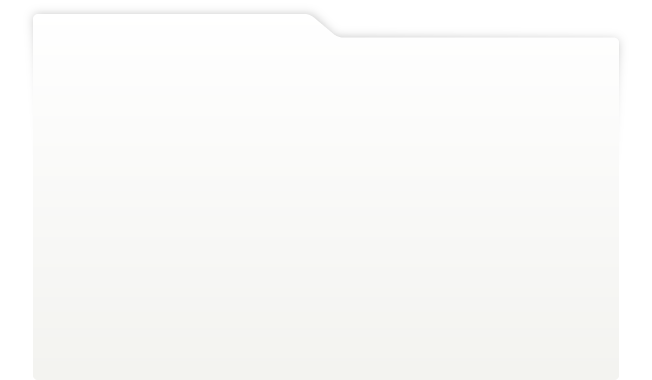
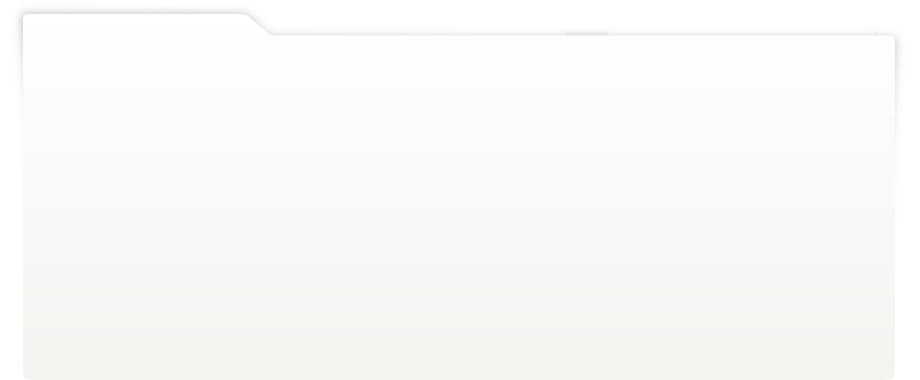
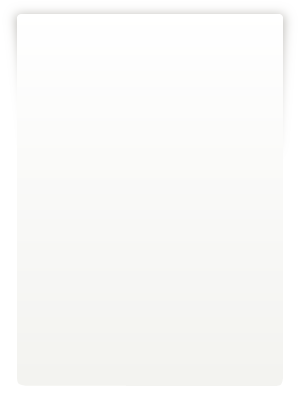
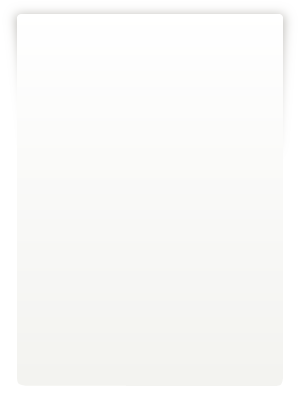
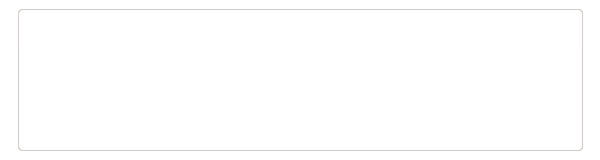
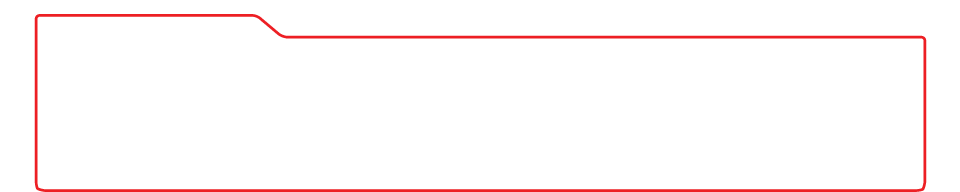
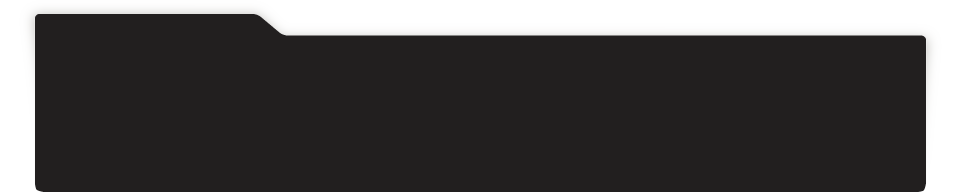
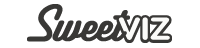
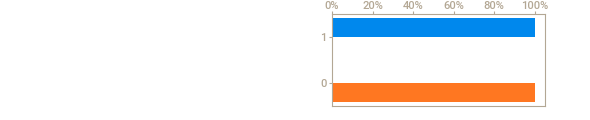
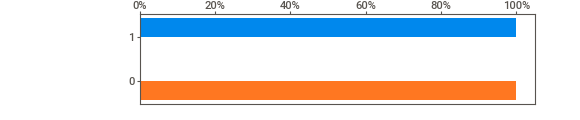
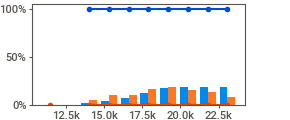
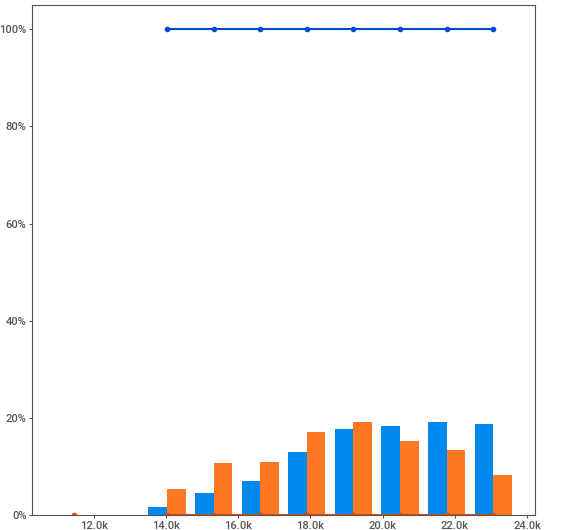
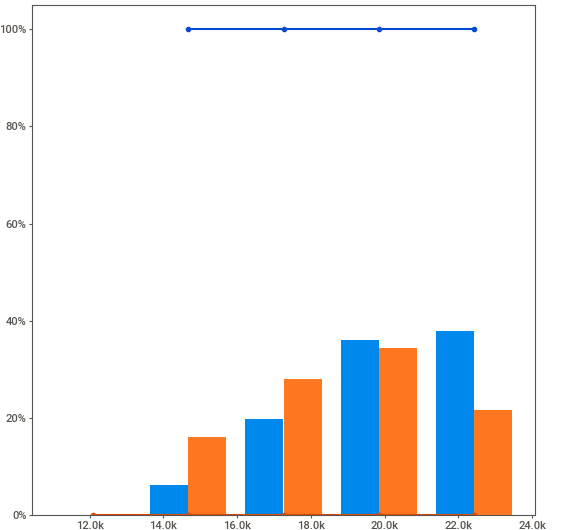
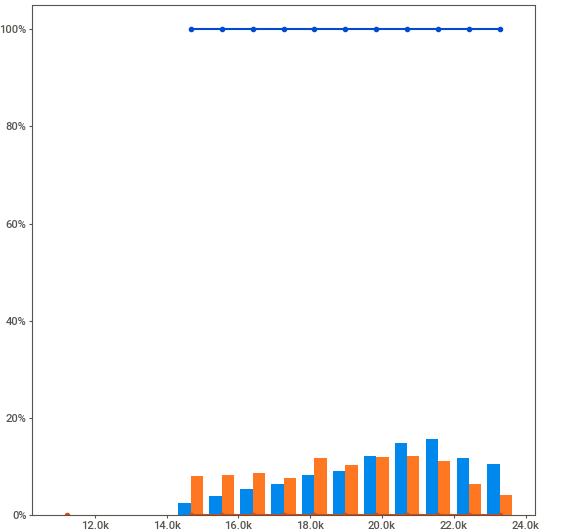
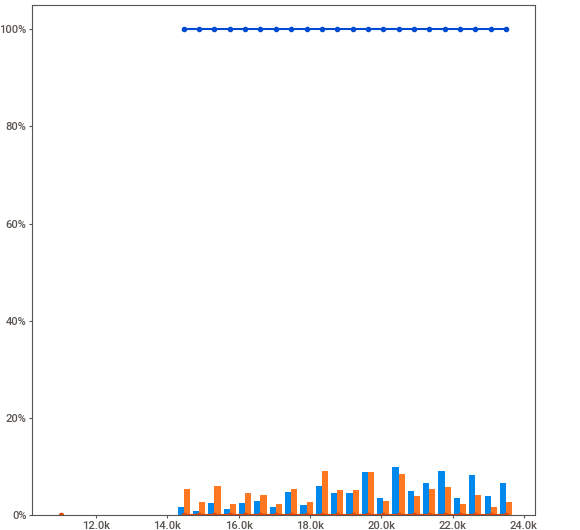
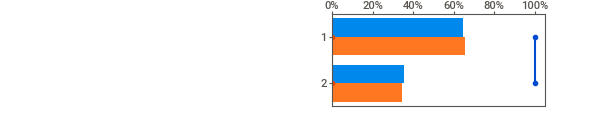
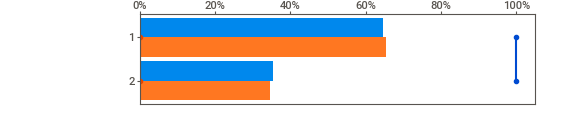
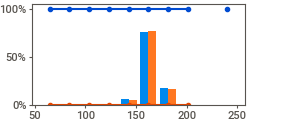
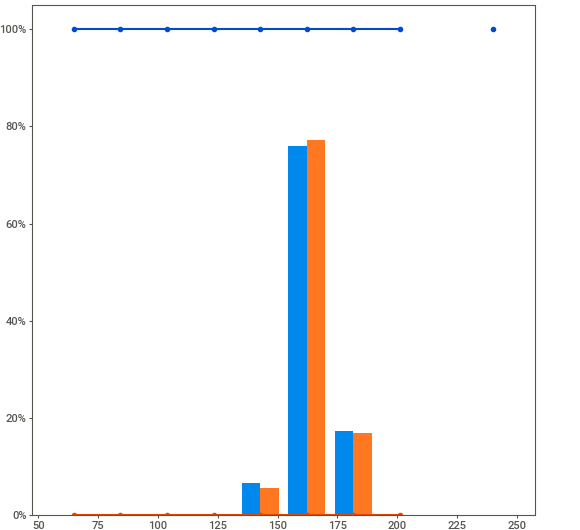
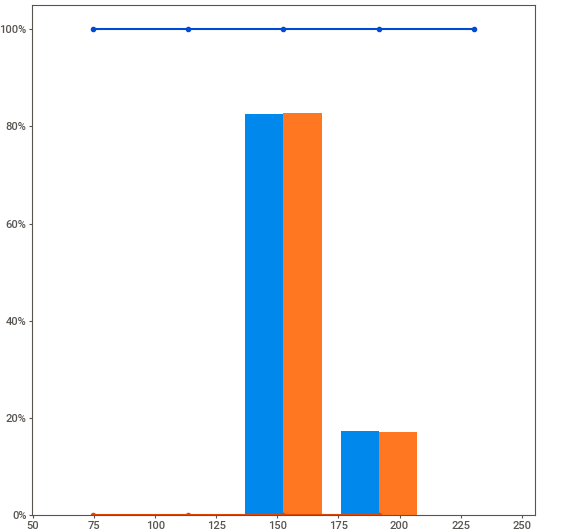
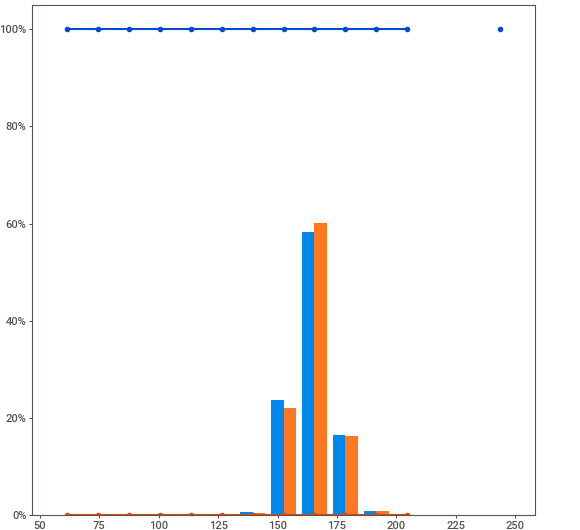
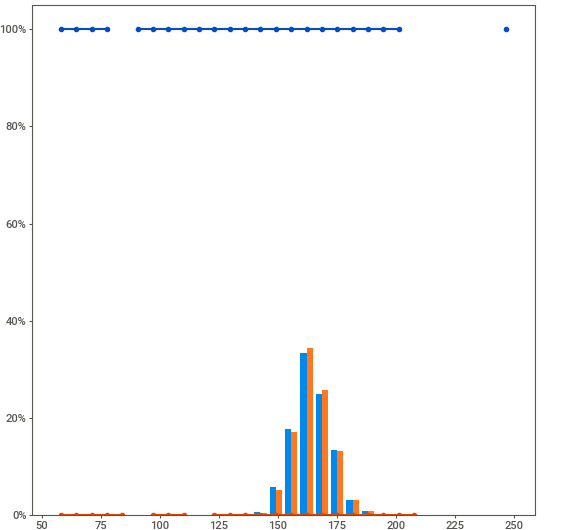
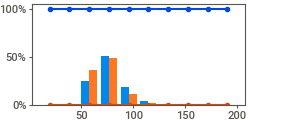
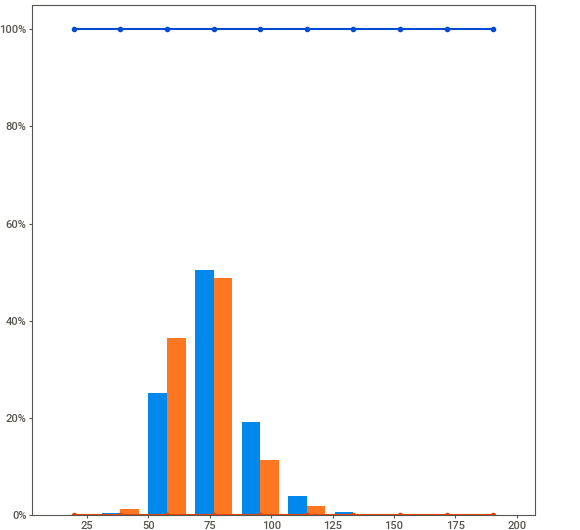
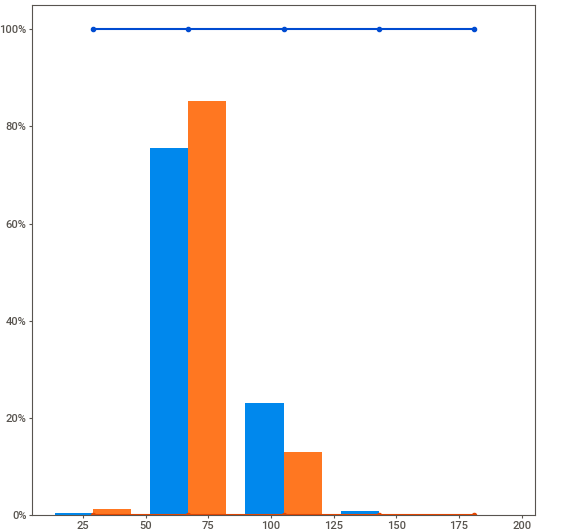
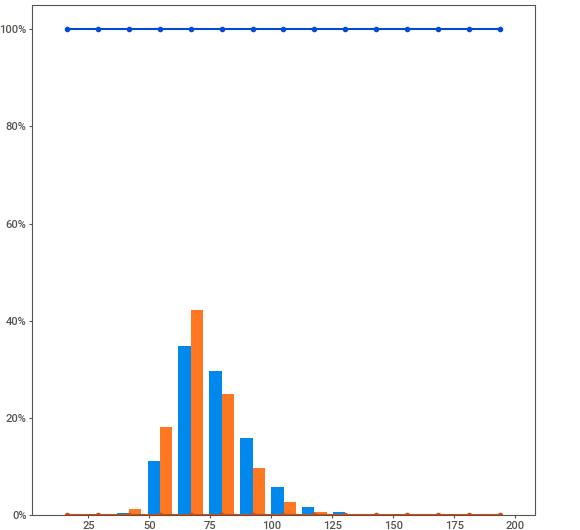
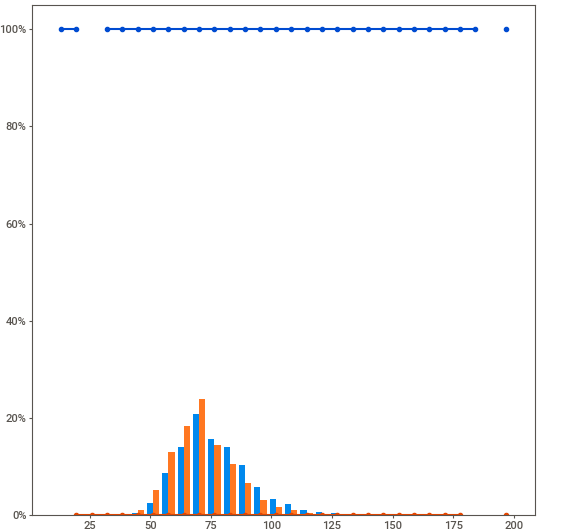
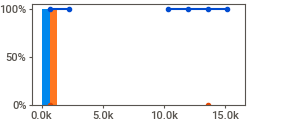
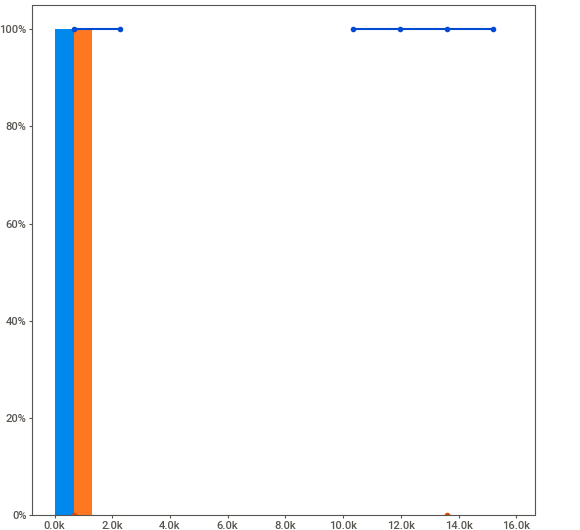
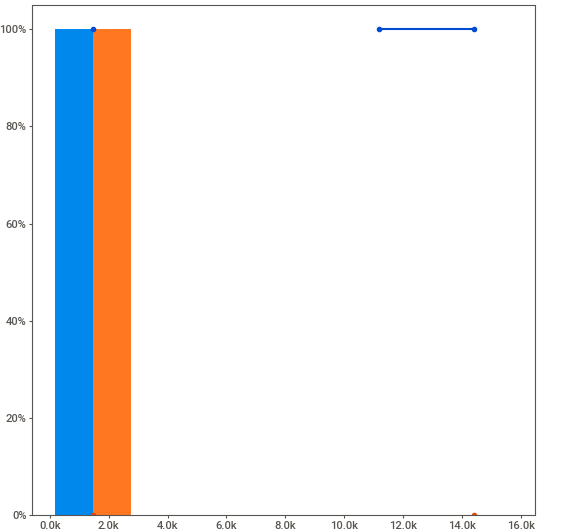
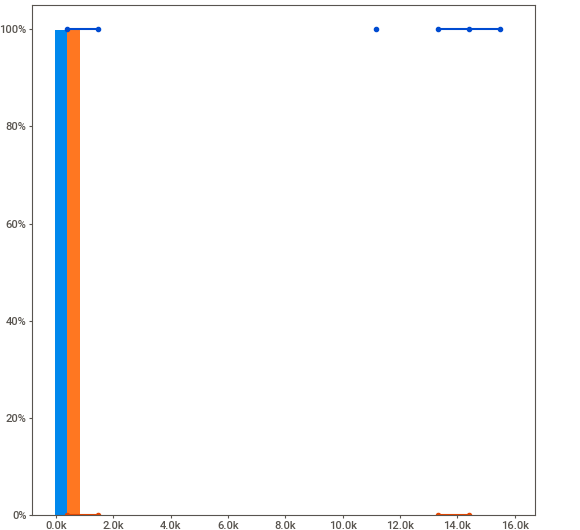
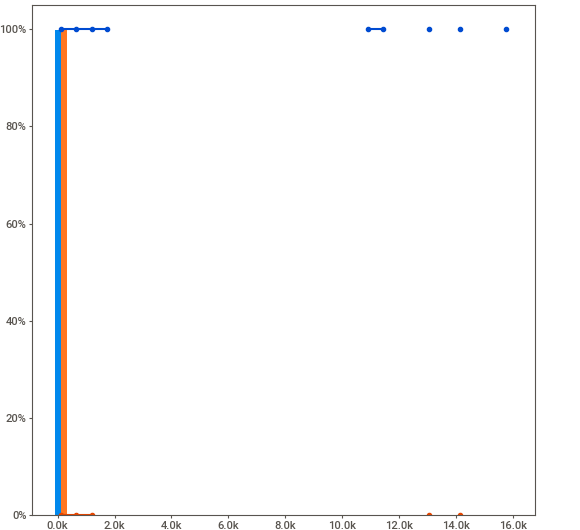
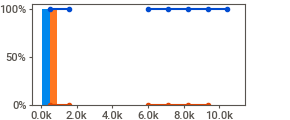
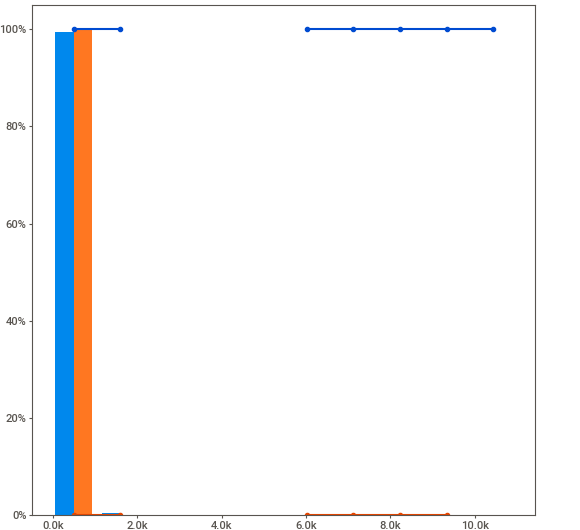
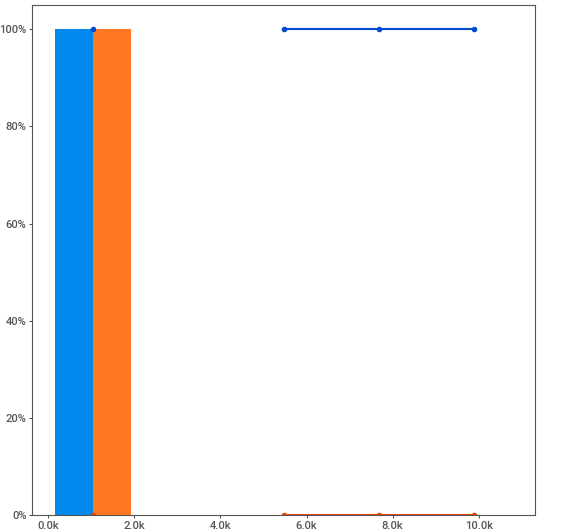
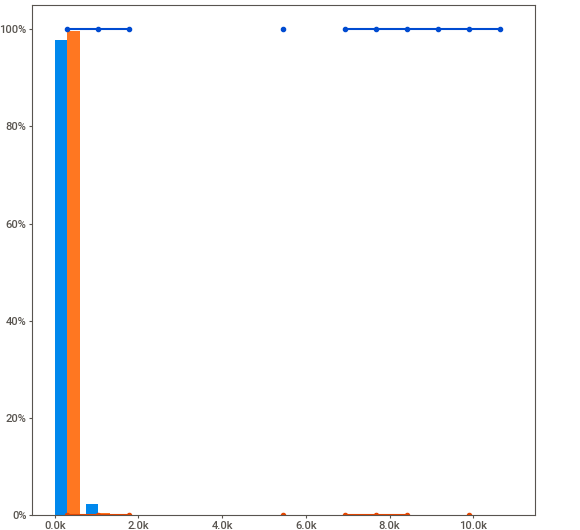
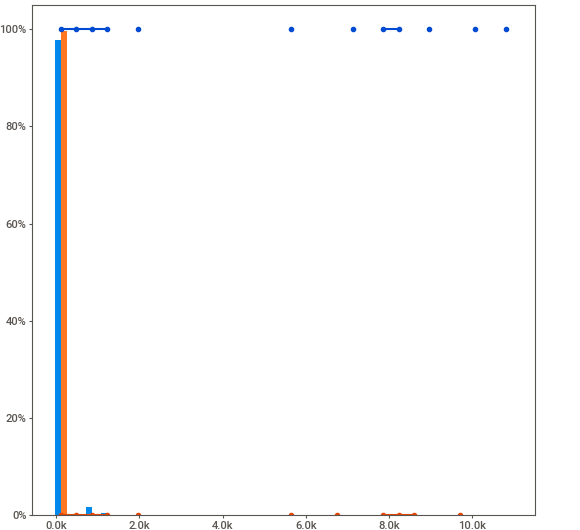
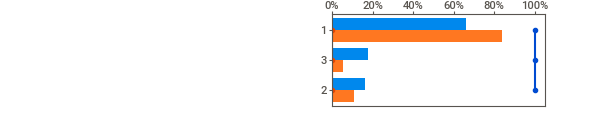
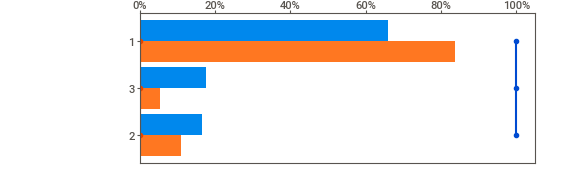
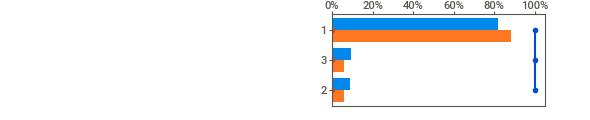
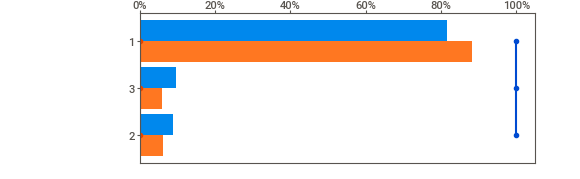
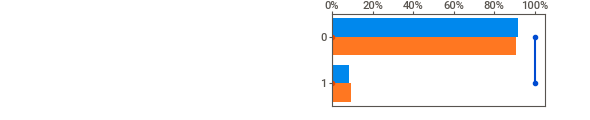
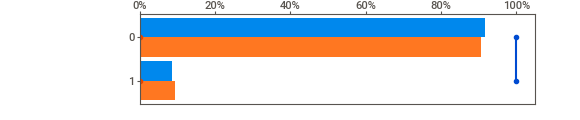
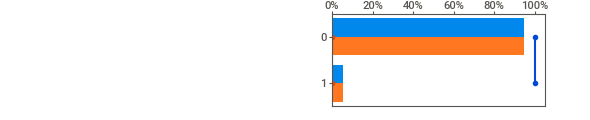
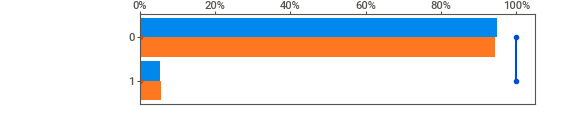
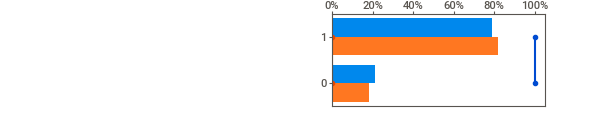
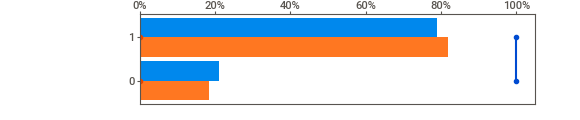
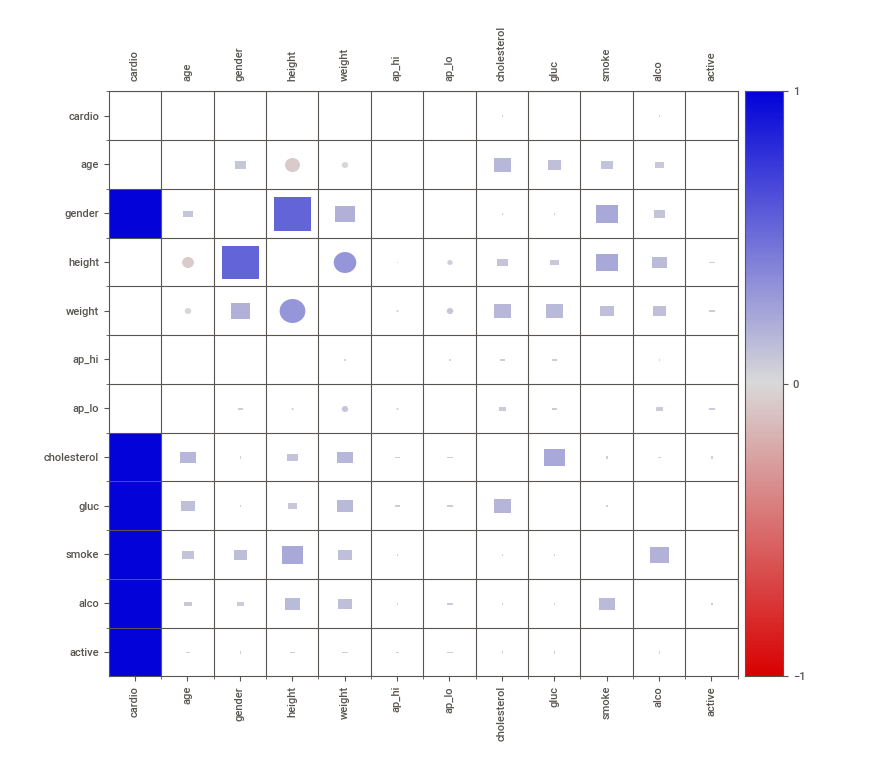
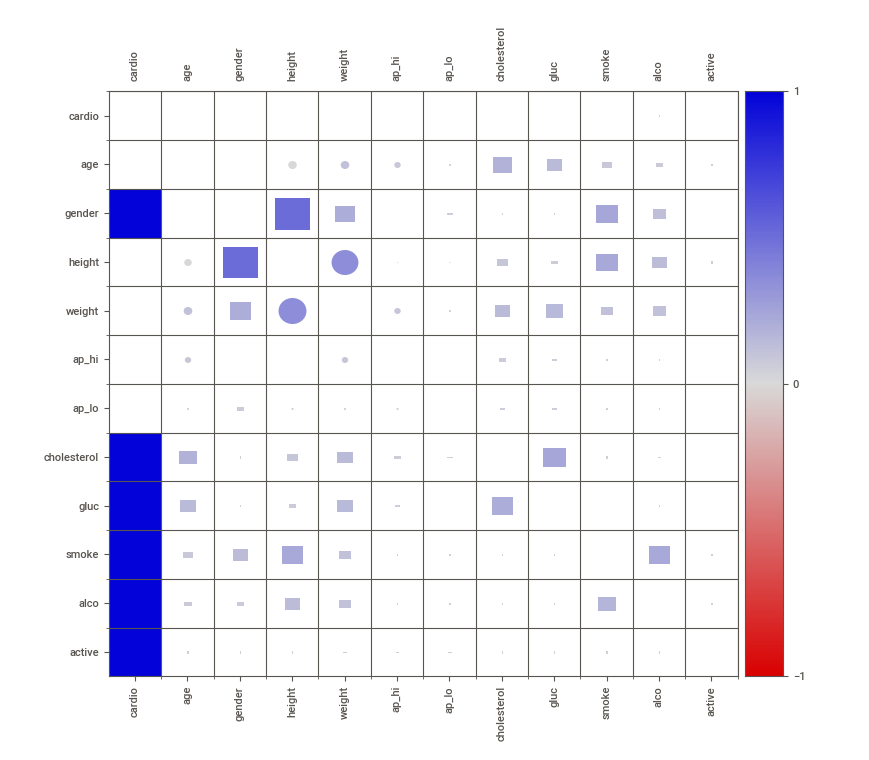

In [47]:
analyze_report = sv.compare_intra(df, df['cardio'] == 1, [str(0), str(1)], 'cardio')
analyze_report.show_notebook(w=1200, h=450, scale=0.8)

Observations:
* orage- healthy, blue-sick
* The data has 34,972 of healthy people and 35,004 of problems with heart health
* The distribution of age for healthy people is a normal population distribution while for people with heart conditions is monotinic an linear
* There is a gender imbalance within the dataset (65%, 35%)
* Gender provides information on cardio
* The mean and median of hight of patients with and without cardio is the same - hight doesn't have immidiate associatinion with cardio but is important in establishing bmi of the patient and from the graph binning hight may have some predictive power
* Standard deviation of weight for cardio patients is highier than for non-cardio patient
* Both mean and median values for weight are highier for cardio patients in comparison with non-cardio patients
* Based on kurtosis of weight the distribution for healthy patients is closer to a normal distribution than the distribution for sick patients which have even lighter tails and fewer extreme values.
* Some values of ap_hi are stored in a negative form, standard deviation for cardio is higher, the same for mean and median value. The distrubition for healthy patients has more outliers and heavier tails.
* Ap_low for healthy patients is almost normal, for sick it has lower number of outliers. The min values are negative.
* Cholesterol level may be a good predictive feature. Majority of the populartion in the dataset has normal cholesterol level. There are more cardio patients with highier cholesterol. Level of cholesterol has a relationship with hight and age.
* Glucose level may be a good predictor.
* Smoking, consumption of alcohol and activity level give information on cardio.


Future steps:
* stratify by gender
* feature engineer bin age, age in years, bmi, mapped hight(short-0, normal-1, tall-3), score_examination (glucose, cholesterol, mapped bmi), score_subjective (smoking, alcohol consumption, activity level)
* replace gender values 1, 2 -> 0, 1
* replace incorrect entries in pressure mesurements by assessing any values below 40 and over 240, change the placement whenever the diastolic was wrongly put as a systolic

# Cleaning the data and engineering new features

In [4]:
ap_lo_repl = { 1100:110,  1000:100,   800:80,  1033:103,  1001:100,  1200: 120,
            10000:100,  8044:80,1044: 104,   9100:91,   902:90,  1008:108,
            2088:208,   802:80,  8000:80,  1022: 102,   850:85,   708:70,
            9011:90,  1011:101,  1007:100,  1177:117,  7100:71,   709:70,
            8500:85,  1110:111,  8099:80,  1088:108,  1077:107, 1120:112,
            1125:112,   8100:81,   710:71,  5700:57,  8079:80,  1111:111,
            1003:100,  1900:190,   809:89,   801:80,  1002:100,   810:81,
            7099:70, 11000:110, 9800:98,  8200:82,  1139:11,   820:82,  1400:140,
            900:90,  6800:68, 700:70,  1101:110,   910:91,  1140:114,  1211:121,
            8077:80,   901:90,   880:88, 870:87,   585:58,   602:60,  10:100,
            8:80,  20:200,   7:70,   6:60,   1:100,   9:90,  15:150, -70:70, 11:110}

ap_high_repl = {14:140,   11:110,   12:120,   10:100,   16:160, -100:100,    7:70,
                15:150,   17:170,    1:100,   13:130, -115:115,   20:200, -140:140,
                -120:120, -150:150,   24:240,   902:90,   906:90,   909:90,
                11500:115,  1420:142,   701:70,  1500:150,   907:90, 14020:140,
                1400:140,  1620:162,  1130:113,     401:40, 16020:160,  1202:120,
                806:80,  1300:130, 1409:140, 11020:110,   960:96, 13010:130,
                1110:111,  1205:120,  2000:200}


def data_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the input dataframe by performing several operations:
    - Drop duplicate rows.
    - Replace gender values (1 -> 0, 2 -> 1).
    - Replace abnormal blood pressure values using predefined dictionaries.
    - Ensure systolic blood pressure (ap_hi) is greater than diastolic blood pressure (ap_lo).
    - Convert all values to integers.

    Args:
    df : pd.DataFrame
        The input dataframe to be cleaned.
    Returns:
    df : pd.DataFrame
        The cleaned dataframe.
    """
    df.drop_duplicates(inplace=True)
    df['gender'] = df['gender'].replace({1: 0, 2: 1})
    df['ap_hi'] = df['ap_hi'].apply(lambda x: ap_high_repl[x] if x in ap_high_repl else x)
    df['ap_lo'] = df['ap_lo'].apply(lambda x: ap_lo_repl[x] if x in ap_lo_repl else x)
    df = df.apply(pressure_check, axis=1)
    df = df.astype(int)
    return df


def pressure_check(row: pd.Series) -> pd.Series:
    """
    Ensure systolic blood pressure (ap_hi) is greater than diastolic blood pressure (ap_lo).
    If not, swap the values.

    Args:
    row : pd.Series
        A row of the dataframe containing blood pressure values.
    Returns:
    row : pd.Series
        The row with corrected blood pressure values if necessary.
    """
    if row['ap_hi'] < row['ap_lo']:
        row['ap_hi'], row['ap_lo'] = row['ap_lo'], row['ap_hi']
    return row


In [5]:
df = data_cleaning(df)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,1,168,62,110,80,1,1,0,0,1,0
1,20228,0,156,85,140,90,3,1,0,0,1,1
2,18857,0,165,64,130,70,3,1,0,0,0,1
3,17623,1,169,82,150,100,1,1,0,0,1,1
4,17474,0,156,56,100,60,1,1,0,0,0,0


In [50]:
# Let's check main statistics
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.00,69976.00,69976.00,69976.00,69976.00,69976.00,69976.00,69976.00,69976.00,69976.00,69976.00,69976.00
mean,19468.95,0.35,164.36,74.21,127.09,81.57,1.37,1.23,0.09,0.05,0.80,0.50
std,2467.37,0.48,8.21,14.40,17.10,9.89,0.68,0.57,0.28,0.23,0.40,0.50
min,10798.00,0.00,55.00,10.00,60.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,17664.00,0.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.00,0.00
50%,19703.00,0.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.00,0.00
75%,21327.00,1.00,170.00,82.00,140.00,90.00,2.00,1.00,0.00,0.00,1.00,1.00
max,23713.00,1.00,250.00,200.00,309.00,200.00,3.00,3.00,1.00,1.00,1.00,1.00


Obesrvations:
* The youngest individual is 29 years old and the oldest is almost 65
* Some continuous variables have rather extreme values which we will remove manually not to loose the patterns.

Takeaway:
* Manual estimation of acceptable values in continuous varialbes

Text(0, 0.5, 'Values')

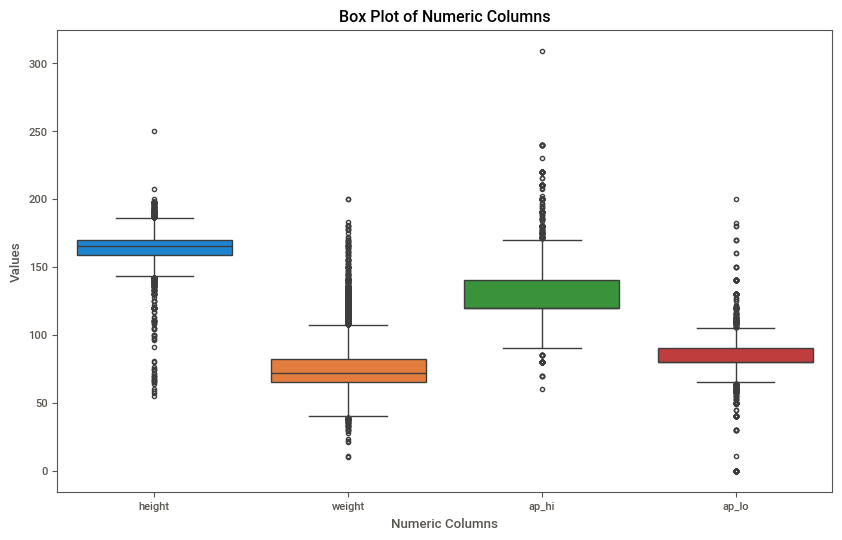

In [51]:
num_col = [
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[num_col])

# Set the title and labels
plt.title('Box Plot of Numeric Columns')
plt.xlabel('Numeric Columns')
plt.ylabel('Values');

We will remove some of the values form diastolic pressure and weight. Other values seems to be reasonable.

In [6]:
# Ranges to keep
ap_lo_range = (30, 150)
weight_range = (30, 250)

print(f'Original shape: {df.shape}')
df = df[(df['ap_lo'] >= ap_lo_range[0]) & (df['ap_lo'] <= ap_lo_range[1]) &
                 (df['weight'] >= weight_range[0]) & (df['weight'] <= weight_range[1])]
print(f'Without outliers shape: {df.shape}')

Original shape: (69976, 12)
Without outliers shape: (69938, 12)


We removed 38 outliers.

# Visualisation of clean dataset


In [53]:
categorical_cols = [col for col in df.columns if df[col].nunique() <= 10]
continuous_cols = df.columns.difference(categorical_cols).tolist()
print(f'Categorical columns: {categorical_cols}')
print(f'Continuous columns: {continuous_cols}')

Categorical columns: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
Continuous columns: ['age', 'ap_hi', 'ap_lo', 'height', 'weight']


<ipython-input-54-49a52e015e98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con.loc[:, 'cardio'] = df['cardio'].values


<Figure size 1500x1500 with 0 Axes>

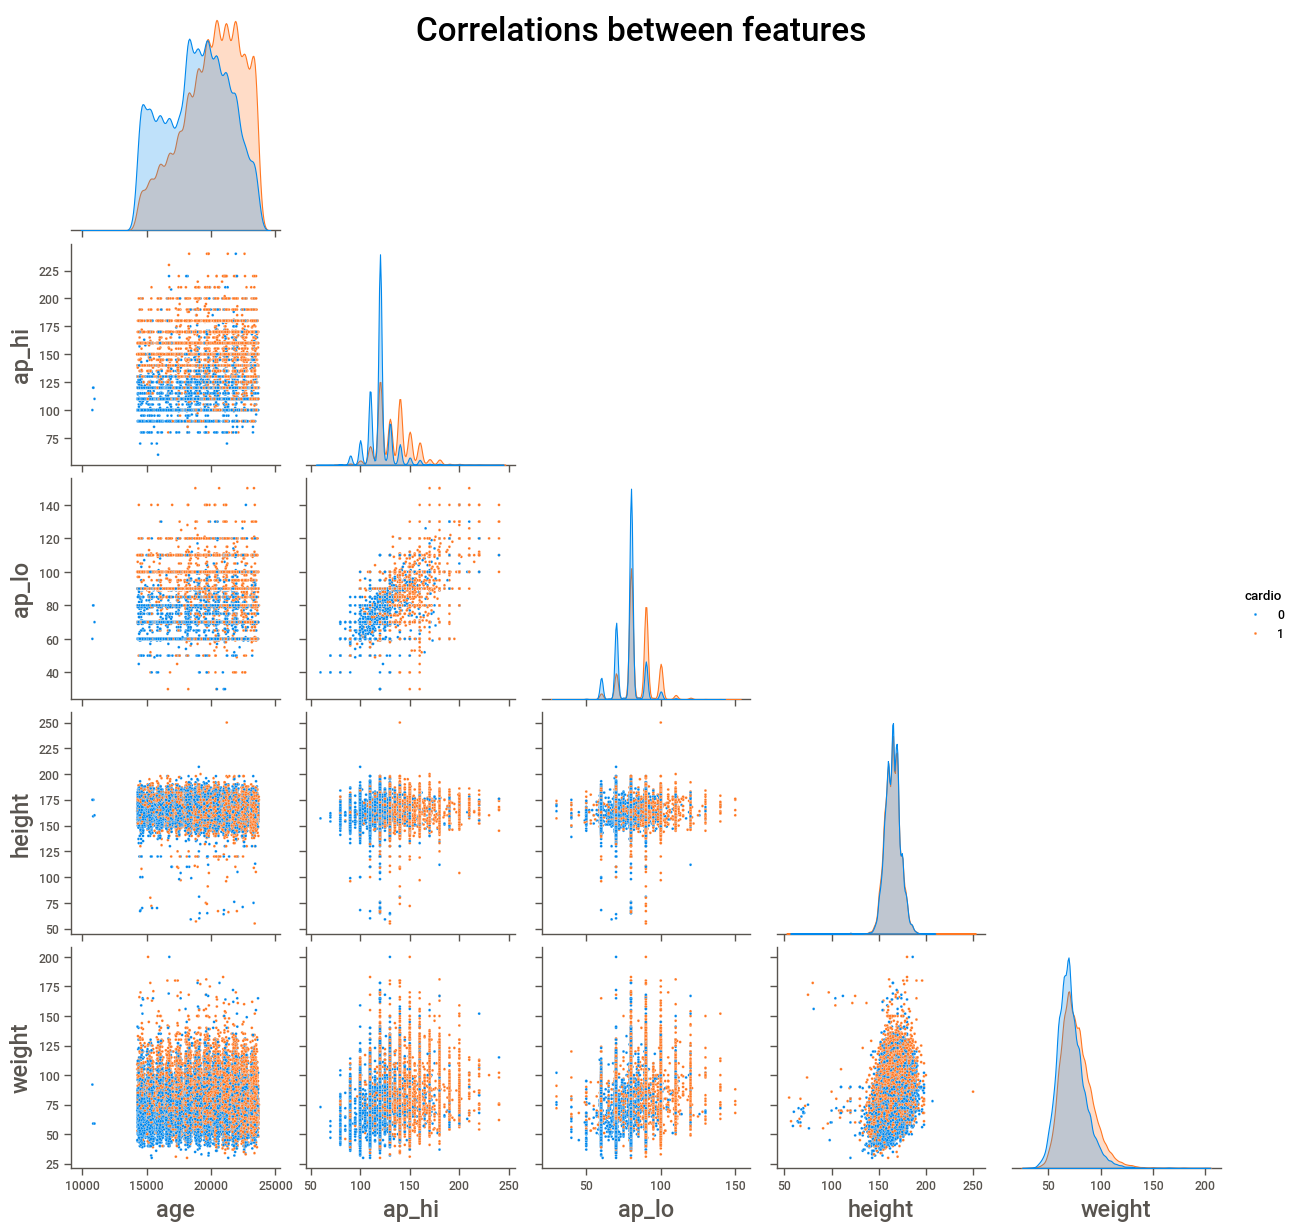

In [54]:
df_con = df[continuous_cols]
df_con.loc[:, 'cardio'] = df['cardio'].values
fig = plt.figure(figsize=(15, 15))
sns.set_context("paper", rc={"axes.labelsize": 17})
g = sns.pairplot(df_con, corner=True, hue="cardio", plot_kws={"s": 4})
g.fig.suptitle("Correlations between features", size=24, fontweight="bold")
plt.show();


The visualisation suggest that ap_hi, ap_low, age and weight may have correlation with either having or not having the disease. Height seems to be less important although for very high individuals most of them may have cardiovascular disease.  
The outcomes are quite noisy but hopefully the algorithms will find paterns.

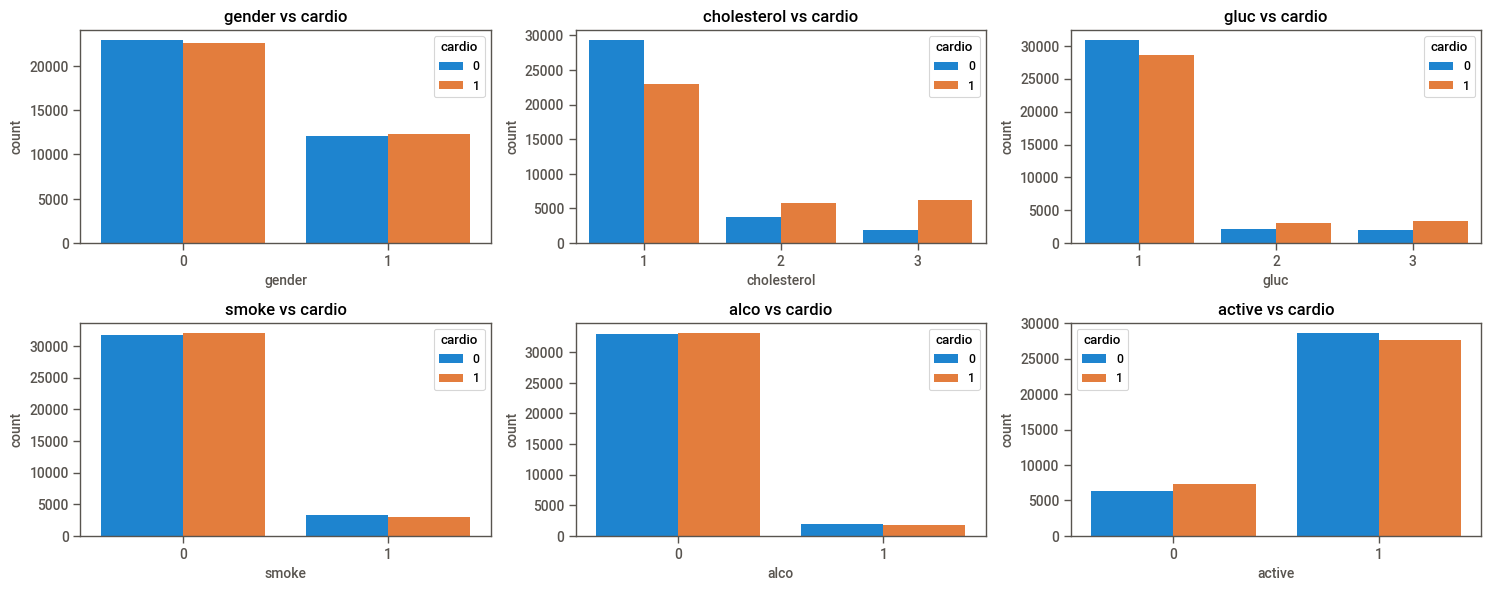

In [55]:
df_cat = df[categorical_cols]
n_rows = int((len(categorical_cols) + 1) / 3)

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows))
axes = axes.flatten()
for ax, col in zip(axes, categorical_cols):
    sns.countplot(data=df_cat, x=col, hue='cardio', ax=ax)
    ax.set_title(f'{col} vs cardio', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)
for i in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

We can spot the biggest differences in cholsterol, glocose. Let's see the phik matrix.

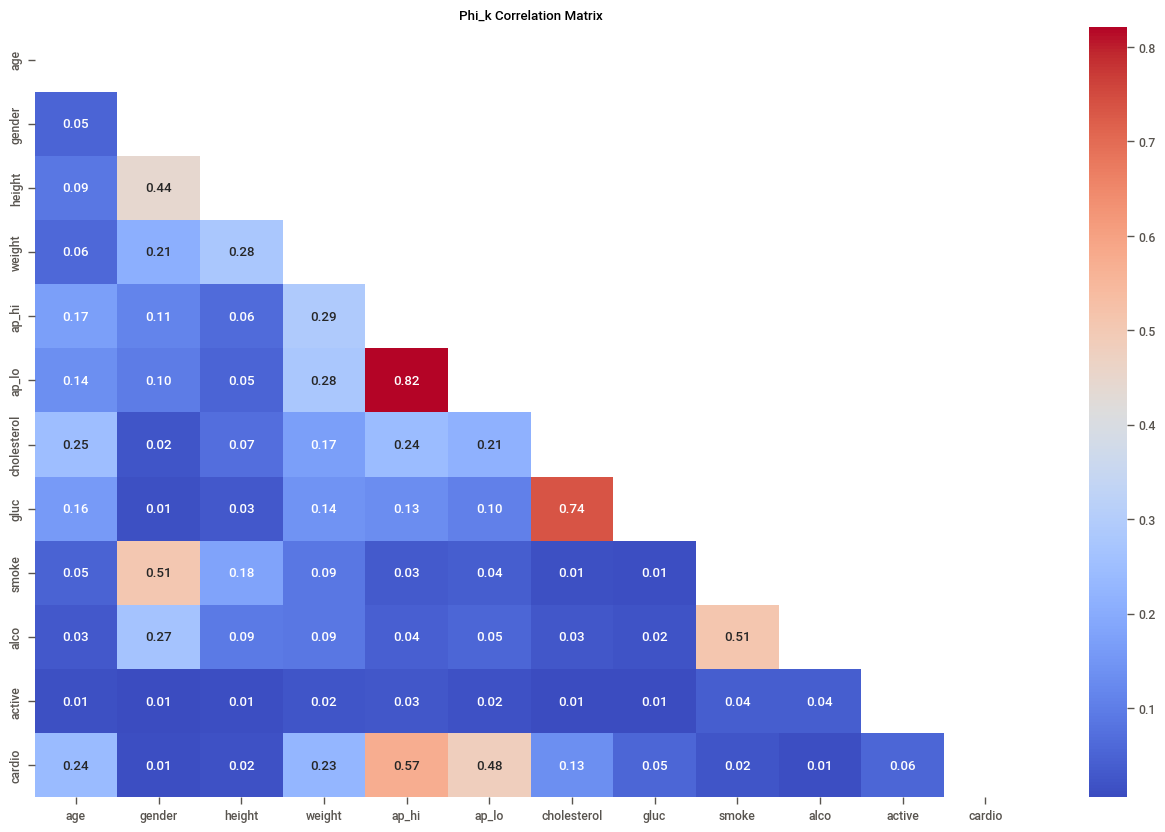

In [56]:
correlation_matrix = df.phik_matrix(interval_cols=df.columns)
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')
plt.title('Phi_k Correlation Matrix')
plt.show()

Observations:
* There are some strong correlations between features: gluc-cholesterol, ap_lo-ap-hi
* pressure and weight may be the best predictive features

# Base classifier

In [7]:
# Data split
X = df.drop(columns=["cardio"])
y = df["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=df[['gender', 'cardio']],
                                                    test_size=0.2, random_state=42)

In [58]:
pipe = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear',
                                      C=1.0, random_state=42, max_iter=200))
])

scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
print_val_score(scores)

Validation scores: [0.73029491 0.72403932 0.725916   0.7310992  0.72841823]
Mean accuracy score: 0.728 (+/- 0.005)


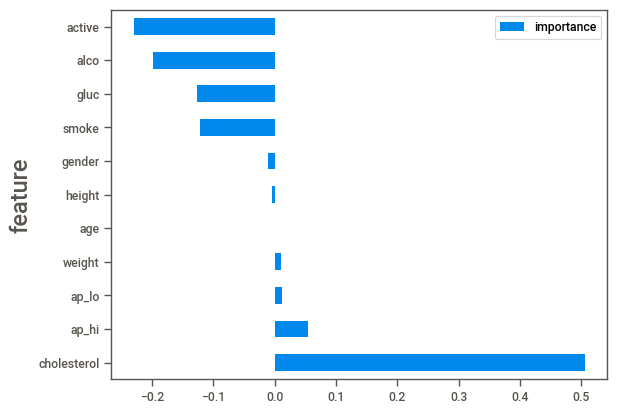

In [59]:
model = pipe.named_steps['classifier']
model.fit(X_train, y_train)
df_importance = pd.DataFrame({'feature': X_train.columns.tolist(),
                              'importance': model.coef_[0]})
df_importance.sort_values(by='importance', ascending=False).plot(kind='barh',
                                                                 x='feature',
                                                                 y='importance');

# Performance of other models

In [60]:
pipeline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('clf', None)
])

models = [
    ('RandomForest', RandomForestClassifier(max_depth=10, n_estimators=20)),
    ('KNN', KNeighborsClassifier(10)),
    ('XGBoost', XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=7))
    ]

for name, model in models:
    pipeline.set_params(clf=model)
    val_score = cross_val_score(pipeline, X_train, y_train, cv=5, verbose=1,
                                scoring='accuracy')
    print(f"Name: {name}")
    print_val_score(val_score)
    print('-'*80)

Name: RandomForest
Validation scores: [0.7411975  0.73074173 0.7279714  0.73413762 0.73413762]
Mean accuracy score: 0.734 (+/- 0.009)
--------------------------------------------------------------------------------
Name: KNN
Validation scores: [0.71581769 0.70732797 0.71429848 0.70929401 0.71331546]
Mean accuracy score: 0.712 (+/- 0.006)
--------------------------------------------------------------------------------
Name: XGBoost
Validation scores: [0.73815907 0.73386953 0.73208222 0.73440572 0.73404826]
Mean accuracy score: 0.735 (+/- 0.004)
--------------------------------------------------------------------------------


So far the XGBoost performs the best on 11 available features. Let's see if we will be able to improve the results by engineering some additional features.

# Feature engineering

## PCA features

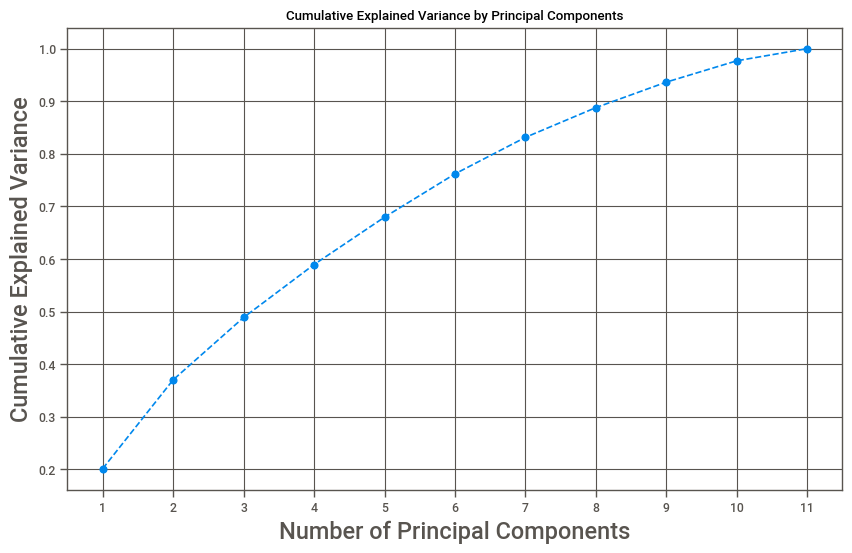

In [61]:
pipeline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('pca', PCA())
])
X_pca = pipeline.fit_transform(X_train, y_train)
# Explained variability by the component
pca = pipeline.named_steps['pca']
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(1, len(cumulative_explained_variance) + 1, step=1))
plt.grid()
plt.show()

First component explains around 0.37 of variance in the dataset. For the following they explain around 0.1 of variance each. Potentially the first component may help predict our target.

Let's visualize first two components hued by the target.

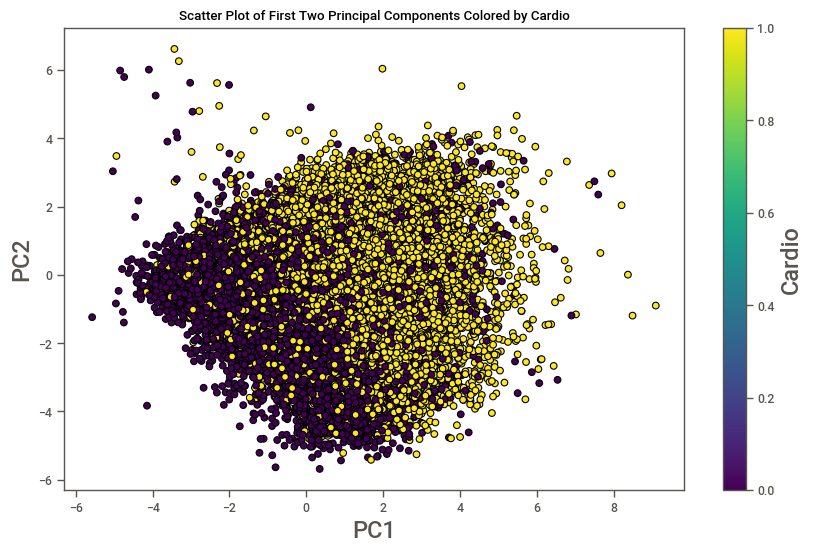

In [62]:
components_df = pd.DataFrame(pca.components_, columns=X_train.columns)
components_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, 12)])
components_df['cardio'] = y_train.values

plt.figure(figsize=(10, 6))
plt.scatter(components_df['PC1'], components_df['PC2'], c=components_df['cardio'], cmap='viridis', edgecolor='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of First Two Principal Components Colored by Cardio')
plt.colorbar(label='Cardio')
plt.show()

We see that the dataset is rather balanced and doesn't have many outliers. Still it may be challanging to separe patients with cardiovascular condition from healthy individuals.

In [63]:
chi2_test(components_df['cardio'], components_df['PC1'])

Chi-square test statistic: 55926.0
p-value: 0.512
The association with 'cardio' is not statistically significant (p >= 0.05).


## Feature based on belonging to the cluster

First let's establish how many clusters there may be in the dataset based on the 1000 random samples

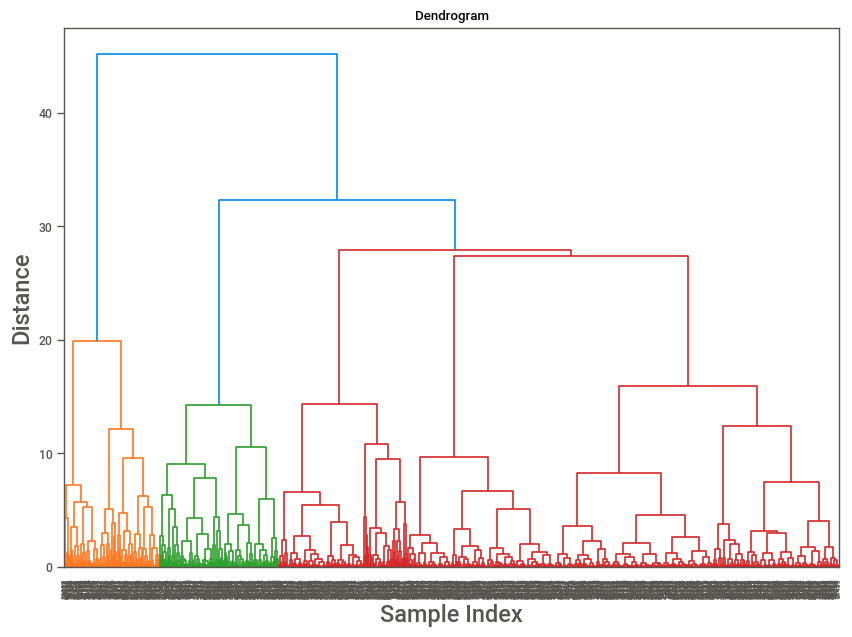

In [64]:
columns_of_interest = ['gluc', 'weight', 'age', 'cholesterol']
X = X_train[columns_of_interest]
X = X.sample(n=1000, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, labels= X.index.tolist())
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

There seems to be 5 distinct clusters. Let's use the KMeans to produce the additional column and asses if its statistically significant.

In [65]:
class KMeansFeature(BaseEstimator, TransformerMixin):
    """
    Custom transformer that adds a cluster feature based on KMeans clustering.
    Args:
    n_clusters : int, optional (default=5)
        The number of clusters to form as well as the number of centroids to generate.
    Attributes:
    kmeans : KMeans
        KMeans clustering model.
    columns : list of str
        List of column names to be used for clustering.
    scaler : StandardScaler
        Standard scaler used for normalizing the features before clustering.
    """

    def __init__(self, n_clusters: int = 5):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
        self.columns = ['gluc', 'weight', 'age', 'cholesterol']
        self.scaler = StandardScaler()

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        X = X.copy()
        X_scaled = self.scaler.fit_transform(X[self.columns])
        self.kmeans = self.kmeans.fit(X_scaled)
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame:
        X = X.copy()
        X_scaled = self.scaler.transform(X[self.columns])
        X['cluster'] = self.kmeans.predict(X_scaled).astype(int)
        return X

    def get_feature_names_out(self, input_features: list = None) -> list:
        return self._feature_names


In [66]:
# Create cluster column and check assiciation with the target
kmf = KMeansFeature()
X_cluster = kmf.fit_transform(X_train, y_train)
chi2_test(X_cluster['cluster'], y_train)

Chi-square test statistic: 4344.823
p-value: 0.0
The association with 'cardio' is statistically significant (p < 0.05).


## Feature based on target mean of nearest neighbours


In [67]:
class NNFeature(BaseEstimator, TransformerMixin):
    """
    Adds a feature of the mean TARGET value of n closest neighbors.
    Args:
    n_neighbors : int, optional (default=5)
        The number of neighbors to use for calculating the mean target value.
    Attributes:
    n_neighbors : int
        The number of neighbors.
    nbrs : NearestNeighbors
        NearestNeighbors model used for finding the nearest neighbors.
    columns : list of str
        List of column names to be used for finding neighbors.
    y_train : pd.Series
        Target values used for calculating the mean of neighbors' target values.
    """

    def __init__(self, n_neighbors: int = 5):
        self.n_neighbors = n_neighbors
        self.nbrs = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.columns = ['gluc', 'weight', 'age', 'cholesterol']

    def fit(self, X: pd.DataFrame, y: pd.Series) -> 'NNFeature':
        X_copy = X.copy()
        self.nbrs = self.nbrs.fit(X_copy[self.columns])
        self.y_train = y
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame:
        X_copy = X.copy()
        nn_idx = self.nbrs.kneighbors(X_copy[self.columns])[1]
        col_name = f'mean_target_of_neighbors_{self.n_neighbors}'
        X_copy[col_name] = [self.y_train.iloc[idx].mean() for idx in nn_idx]
        return X_copy

    def get_feature_names_out(self, input_features: list = None) -> list:
        return self._feature_names


In [68]:
feature_adder = NNFeature()
# Fit and transform the dataset
X_mean = feature_adder.fit_transform(X_train, y_train)
chi2_test(X_mean['mean_target_of_neighbors_5'], y_train)

Chi-square test statistic: 15422.103
p-value: 0.0
The association with 'cardio' is statistically significant (p < 0.05).


## Pipeline with all engineered features

In [69]:
def map_height(height: Union[int, float]) -> int:
    """
    Map height to categorical values.

    Args:
    height : int or float
        The height value to be mapped.
    Returns:
    int
        The categorical value corresponding to the height.
    """
    if height < 150:
        return 0
    elif 150 <= height < 170:
        return 1
    elif height >= 170:
        return 2

class FeatureCreation(BaseEstimator, TransformerMixin):
    """
    Engineer features based on mathematical transformations.

    This transformer adds several new features to the input dataframe:
    - Body Mass Index (BMI)
    - Examination score based on glucose and cholesterol levels
    - Subjective score based on smoking, alcohol consumption, and activity levels
    - Height range category
    - Pulse pressure
    """

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame:
        X['bmi'] = X['weight'] / ((X['height'] / 100) ** 2)
        X['score_examination'] = X['gluc'] + X['cholesterol']
        X['score_subjective'] = X['smoke'] + X['alco'] + X['active']
        X['height_range'] = X['height'].apply(map_height)
        X['pulse_pressure'] = X['ap_hi'] - X['ap_lo']
        X = X.astype(int)
        return X

    def get_feature_names_out(self, input_features: list = None) -> list:
        return self._feature_names


Let's check how much value our new feature bring to RadomForestClassifier.

In [70]:
initial_pipeline = Pipeline([
    ('feature_creation', FeatureCreation()),
    ('clf', RandomForestClassifier(max_depth=10, n_estimators=20))
])
print('Initial pipeline with domain features')
initial_val_score = cross_val_score(initial_pipeline, X_train, y_train, cv=5, verbose=1, scoring='accuracy')
print_val_score(initial_val_score)

print('-'* 100)
print('Pipeline with domain features, target mean and cluster features')
pipeline = Pipeline([
     ('feature_creation', FeatureCreation()),
    ('kmeans_feature', KMeansFeature()),
    ('nn_feature', NNFeature()),
    ('clf', RandomForestClassifier(max_depth=10, n_estimators=20))

])
val_score = cross_val_score(pipeline, X_train, y_train, cv=5, verbose=1, scoring='accuracy')
print_val_score(val_score)

Initial pipeline with domain features
Validation scores: [0.73967828 0.72877569 0.7282395  0.73154602 0.73306524]
Mean accuracy score: 0.732 (+/- 0.008)
----------------------------------------------------------------------------------------------------
Pipeline with domain features, target mean and cluster features
Validation scores: [0.69553172 0.69276139 0.69213584 0.69436997 0.69204647]
Mean accuracy score: 0.693 (+/- 0.003)


Seems like additional features made the model more confused. Apparently there is a lot of noise which will need to be removed. We will address this by spliting the train set into two sets, removing multicollinear features manually and trying to improve the performance of our model.

# Feature selection

## Selecting features based on removal of multicollinearity

To remove multicollinear feature we will use the code from sklearn documentation notebook: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

We will cluster the features based on the spearman correlation between the features, then compare with phik correlations to the target of all the feeatures in the cluster and chosing the one that have the highiest correaltion with the target.

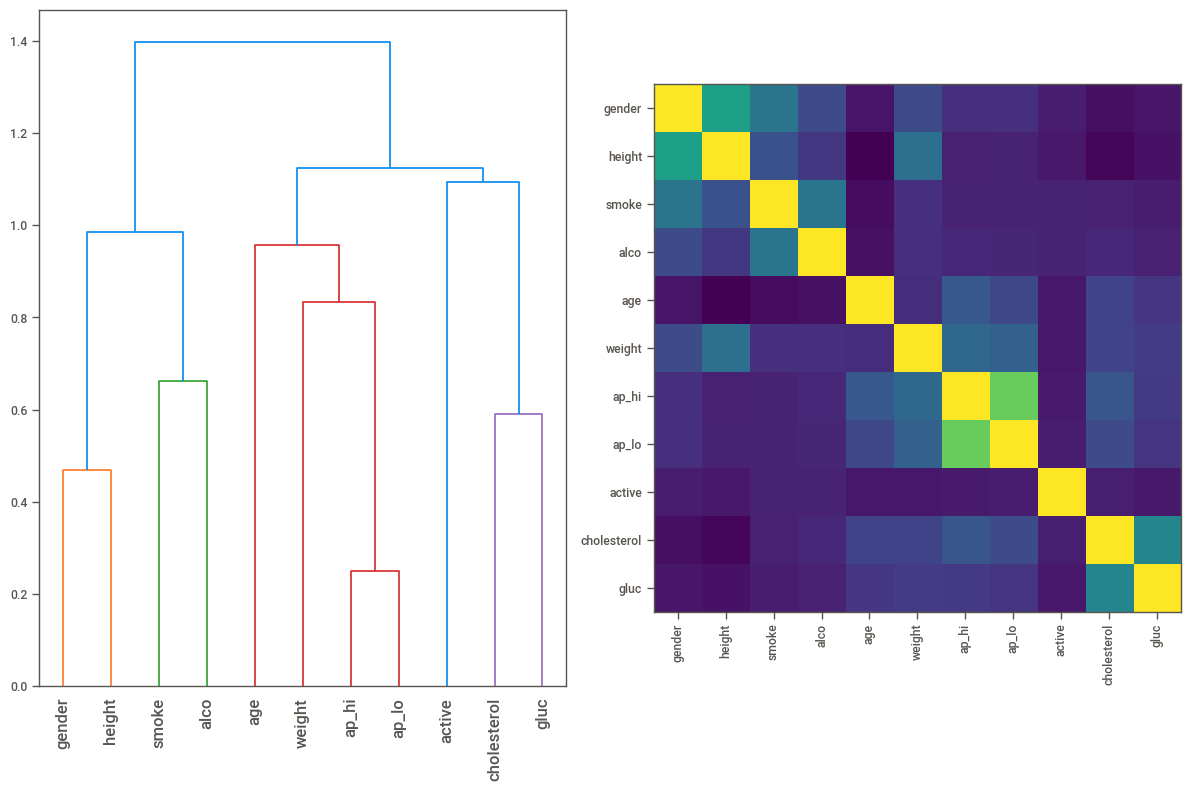

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [72]:
# Correlation with the target phik
df_phik = X_train.copy()
df_phik['cardio'] = y_train
# Calculate the correlation matrix using Phik
phik_matrix = df_phik.phik_matrix(interval_cols=df_phik.columns)

# Extract the correlation to the target 'cardio'
cardio_corr = phik_matrix['cardio'].sort_values(ascending=False)
print(cardio_corr)


cardio        1.00
ap_hi         0.57
ap_lo         0.48
age           0.24
weight        0.22
cholesterol   0.13
active        0.06
gluc          0.05
smoke         0.02
height        0.02
gender        0.01
alco          0.01
Name: cardio, dtype: float64


In [73]:
selected_features = ['height', 'smoke', 'age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol']
X_train_sel = X_train[selected_features]
rf = RandomForestClassifier(max_depth=10, n_estimators=20)
val_score = cross_val_score(rf, X_train_sel, y_train, cv=5, verbose=1, scoring='accuracy')
print(f'Validation scores: {val_score}')
print(f"Mean accuracy score: {val_score.mean():.3f} (+/- {val_score.std() * 2:.3f})")


Validation scores: [0.73592493 0.72957998 0.7310992  0.72904379 0.73181412]
Mean accuracy score: 0.731 (+/- 0.005)


Each attempt seems to bring worst results. The next attempt to select better set of features will be using boruta.

## Selecting features with Boruta

In [74]:
fc = FeatureCreation()
X_feature = fc.fit_transform(X_train, y_train)

# Dealing with deprication
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=1)
boruta_selector.fit(np.array(X_feature), np.array(y_train))

selected_features = X_feature.columns[boruta_selector.support_].tolist()
feature_ranking = boruta_selector.ranking_

print(f"Selected features: {selected_features}")
print(f"Feature ranking: {feature_ranking}")

Selected features: ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'bmi', 'score_examination', 'pulse_pressure']
Feature ranking: [1 6 2 1 1 1 1 3 7 9 5 1 1 4 8 1]


In [75]:
support_features = X_feature.columns[boruta_selector.support_].to_list()
weak_support_features = X_feature.columns[boruta_selector.support_weak_].to_list()
print('features in the green area:', support_features)
print('features in the blue area:', weak_support_features)
X_boruta = X_feature[support_features]

features in the green area: ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'bmi', 'score_examination', 'pulse_pressure']
features in the blue area: []


In [76]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Select chosen features from the dataframe."""

    def __init__(self, support_features):
        self.support_features = support_features
        self._feature_names = support_features

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X = X[support_features]
        return X

    def get_feature_names_out(self, input_features=None):
        return self._feature_names

In [77]:
select_pipe = Pipeline([
    ('feature_creation', FeatureCreation()),
    ('feature_selector', FeatureSelector(support_features)),
    ('clf', RandomForestClassifier(max_depth=10, n_estimators=20))
])
val_score = cross_val_score(select_pipe, X_train, y_train, cv=5, verbose=1, scoring='accuracy')
print_val_score(val_score)

Validation scores: [0.73476318 0.73011618 0.7279714  0.73038427 0.72904379]
Mean accuracy score: 0.730 (+/- 0.005)


The scores are still lower than training the model only on the initial cleaned dataset. Now we will build an XGBoost model and tune it's hyperparameters.

# Hyperparameters tuning for XGBClassifier

In [78]:
X = df.drop(columns=["cardio"])
y = df["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df[['gender', 'cardio']], test_size=0.2, random_state=42)

xgb = XGBClassifier(random_state=42)
param_xgb = {
    'n_estimators': np.arange(50, 201, 50),  # Values: 50, 100, 150, 200
    'max_depth': np.arange(3, 9, 2),  # Values: 3, 5, 7, 9
    'learning_rate': np.logspace(-3, -1, 3),  # Values: 0.001, 0.01, 0.1
    'subsample': np.linspace(0.5, 1.0, 6),  # Values: 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
    'reg_alpha': np.logspace(-2, 1, 4),  # Values: 0.01, 0.1, 1, 10
}

grid_search = RandomizedSearchCV(xgb, param_distributions=param_xgb, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'subsample': 1.0, 'reg_alpha': 10.0, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1}
Best score: 0.7352278820375335


# Final model

In [8]:
# xgb = grid_search.best_estimator_
best_params = {'subsample': 1.0, 'reg_alpha': 10.0, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1}
xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

y_pred_train = xgb.predict_proba(X_train)[:, 1]
y_pred_test = xgb.predict_proba(X_test)[:, 1]

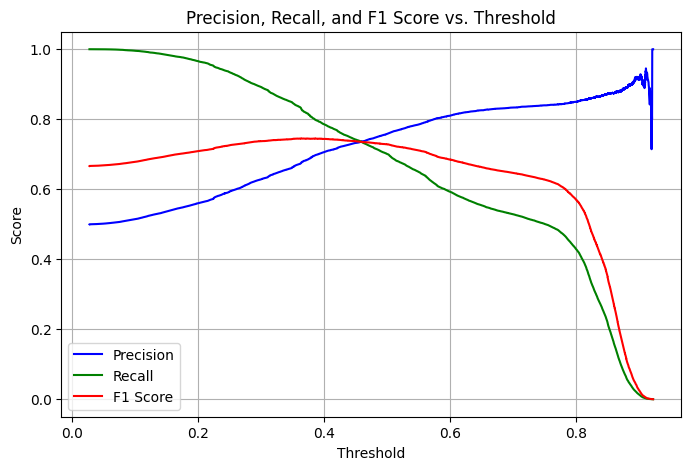

In [9]:
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
f1_scores = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='g')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='r')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

If we want to balance the outcome of the model between recall and precision, the best threshold would be 0.45.

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      6997
           1       0.73      0.75      0.74      6991

    accuracy                           0.74     13988
   macro avg       0.74      0.74      0.74     13988
weighted avg       0.74      0.74      0.74     13988



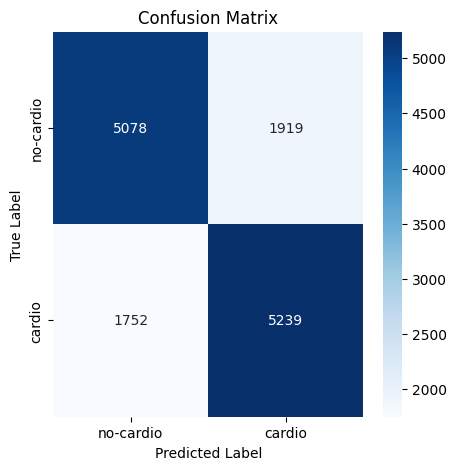

In [10]:
thre = 0.45
y_pred = (y_pred_test > thre).astype(int)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion metrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['no-cardio',  'cardio'],
            yticklabels=['no-cardio', 'cardio'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The model predicts the positive class slightly better. We still could change the threshold to set it to even highier recall. Around 1/3 of the samples seems to be much harder to predict which may suggest that we are lacking some essential feature.

## Model explainibility and checking the worst predictions

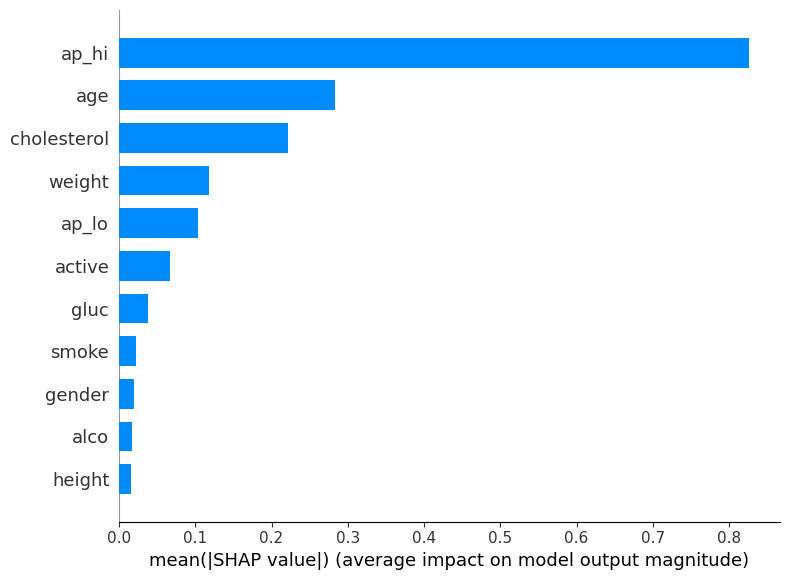

In [11]:
# Getting the explainer and shap values
import shap
exp = shap.TreeExplainer(xgb)
vals = exp.shap_values(X_test)
fig, ax = plt.subplots(figsize=(6, 4))
shap.summary_plot(vals, X_test, plot_type="bar")

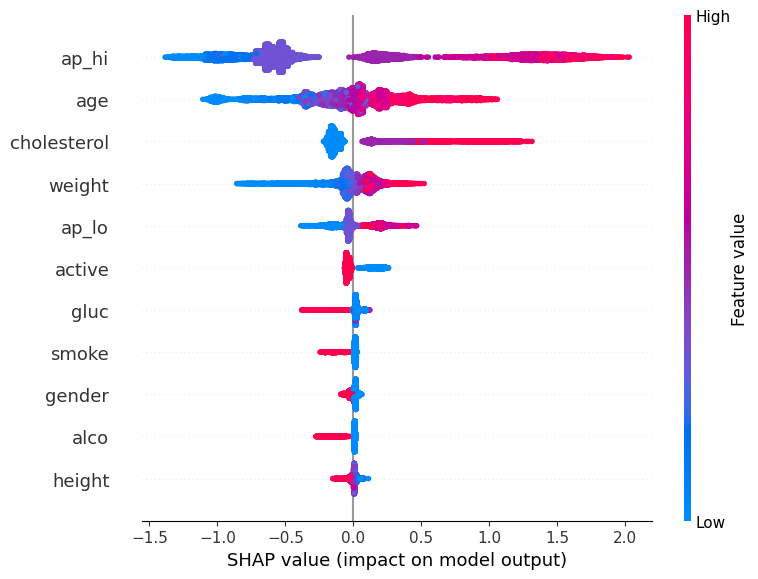

In [15]:
shap.summary_plot(vals, X_test)

Observations:
* high pressure, age, cholesterol and weight are the most important features in predictions of cardiovascular disease
* cholesterol, being active, smoking and alcohol consumption are the most separable features

## Bias explanation

In [12]:
df_results = X_test.copy()
df_results['cardio'] = y_test
df_results['prob'] = y_pred_test
df_results['test_diff'] = abs(df_results['cardio'] - df_results['prob'])
df_results = df_results.sort_values(by='test_diff', ascending=False)

In [13]:
# Let's take 100 worstly predicted results and check the distribution of values
df_results[:100].describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,prob,test_diff
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,18402.93,0.27,161.88,71.92,129.94,80.45,1.81,1.14,0.09,0.05,0.80,0.54,0.46,0.90
std,3317.04,0.45,7.59,18.86,24.85,12.83,0.94,0.38,0.29,0.22,0.40,0.50,0.40,0.02
min,14291.00,0.00,145.00,40.00,90.00,50.00,1.00,1.00,0.00,0.00,0.00,0.00,0.04,0.88
25%,15196.75,0.00,156.00,58.00,110.00,70.00,1.00,1.00,0.00,0.00,1.00,0.00,0.10,0.89
50%,17873.00,0.00,162.00,67.50,120.00,80.00,1.00,1.00,0.00,0.00,1.00,1.00,0.11,0.89
75%,21850.25,1.00,166.00,82.25,150.00,90.00,3.00,1.00,0.00,0.00,1.00,1.00,0.89,0.91
max,23611.00,1.00,183.00,155.00,185.00,119.00,3.00,3.00,1.00,1.00,1.00,1.00,0.92,0.96


Observations:
* age of wrongly predicted were people from 39+ years old
* there were more wrongly predicted women than men
* patients of average height and rather slim
* with normal to low pressure and low glucose and normal cholesterol
* majority didn't smoke, consumed alcohol and were more active than population

In [14]:
X_shap = df_results[:100].drop(columns=['cardio', 'prob', 'test_diff']).reset_index(drop=True)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_shap)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


For this 50-year-old woman, who had good blood pressure and slightly higher cholesterol but a normal weight, the model predicted being healthy while she actually had cardiovascular disease. There may be additional features, which could be obtained through further examinations, that would improve the model's performance. Classifying individuals who exhibit most characteristics of a healthy person can be extremely challenging unless we identify additional predictive features.


# Conclusions

* The model has a tendency to classify individuals with the following characteristics as being at higher risk for cardiovascular disease: high cholesterol, older age, higher weight, and higher blood pressure. However, there are still one-third of individuals who exhibit these characteristics and remain healthy, as well as individuals who do not exhibit these characteristics but are prone to cardiovascular disease.

* To improve the model's performance, we could potentially explore individuals who were misclassified, both false positives and false negatives, to identify additional features that could enhance accuracy. While creating additional features based on domain knowledge, target mean of the five nearest neighbors, and classification into five different clusters was attempted, it introduced more noise into the models.

* Despite these challenges, we were able to improve the model's performance from a baseline accuracy of 0.72 to 0.74 by employing more sophisticated algorithms and hyperparameter tuning. However, feature selection often led to the loss of crucial information necessary for accurate predictions.